https://satijalab.org/seurat/archive/v3.0/multimodal_vignette.html

# Introduction
This notebook is adapted from [Nikolay Oskolkov's](https://github.com/NBISweden/workshop_omics_integration/blob/main/session_ml/DeepLearningDataIntegration/DeepLearningDataIntegration.html) wonderful writeup on genomics data integration. 

Biological and biomedical research has been tremendously benefitting in the last decade from the rapid technological advancement of DNA sequence (genomics), gene expression (transcriptomics), protein abundance (proteomics) and many other levels of biological information commonly known as OMICs. Despite the power of each individual OMICs layers, their integration and consequent synergistic benefits from their complementarity promise new insights into behaviour of biological system such as cells, tissues and organisms. Hence, integration of multi-omics data paves the future for our quest in biological research.

<figure>
<center>
<img src = https://miro.medium.com/max/700/1*07w_9XFMkzPXIY7rWOptUA.jpeg>
<figcaption> Source: https://science.sciencemag.org/content/358/6359/69.long</figcaption></center>
</figure>



## Single Cells make Big data

The problem of data integration isn't entirely new for data science. Imagine we know that a person looks at a certain images, reads, certain texts and listens to certain music. Image, text and sound are very different types of data, however we can try to combine those types of data to build e.g. a better recommender system which achieves a higher accuracy of capturing the interests of the person. 

As for biology, several data integration methods have been developed in recent years. [mixOmics](http://mixomics.org/), [MOFA](http://msb.embopress.org/content/14/6/e8124), [Similartiy Network Fusion (SNF)](https://www.nature.com/articles/nmeth.2810) and [Bayesian Networks](http://www.bnlearn.com/) are the commonly used ones. 

One common problem in data integration is **the curse of dimensionality**, i.e. inability to work in high-dimensional space with limited number of statistical observations, which is a typical setup for biological data analysis. This is where Single Cell OMICs technologies are very helpful as they deliver hundreds of thousands and even millions of statistical observations (cells) and thus are ideal for data integration. 
<figure>
<center>
<img src = https://miro.medium.com/max/700/1*uQPnZ9AGh37LvdibRGTumg.png>
<figcaption> Source: https://www.frontiersin.org/articles/10.3389/fcell.2018.00028/full </figcaption></center></figure>

Specifically, here we will analyze 2 such multi-omics technologies: [CITEseq](https://www.nature.com/articles/nmeth.4380) and [scNMTseq](https://www.nature.com/articles/s41467-018-03149-4) which provide two and three levels of biological information, respectively, from exactly the same cells. [Nikolay](https://towardsdatascience.com/deep-learning-for-single-cell-biology-935d45064438) has also explained excellently on why deep learning methods such as *Autoencoder* is ideally suited to capture highly non-linear nature of single-cell omics data. Briefly, some benefits are due to the fact that single cell analysis is essentially unsupervised.



## Integrating CITEseq data with Deep Learning

Firstly, we will look at a dataset of 8,617 cord blood mononuclear cells (CBMCs), produced with CITE-seq, where we simultaneously measure the single cell transcriptomes alongside the expression of 11 surface proteins, whose levels are quantified with DNA-barcoded antibodies. Initially, we load in two count matrices : one for the RNA measurements, and one for the antibody-derived tags (ADT). 

In [ ]:
! rm *
# ! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE100nnn/GSE100866/suppl/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz
# ! gunzip GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz
# ! mv GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv scProteomics.csv

# ! wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE100nnn/GSE100866/suppl/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz
# ! gunzip GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz
# ! mv GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv scRNAseq.csv

! wget https://github.com/NikolayOskolkov/DeepLearningDataIntegration/raw/master/scRNAseq.txt
! wget https://github.com/NikolayOskolkov/DeepLearningDataIntegration/raw/master/scProteomics.txt


rm: cannot remove 'sample_data': Is a directory
--2022-01-15 06:59:39--  https://github.com/NikolayOskolkov/DeepLearningDataIntegration/raw/master/scRNAseq.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NikolayOskolkov/DeepLearningDataIntegration/master/scRNAseq.txt [following]
--2022-01-15 06:59:39--  https://raw.githubusercontent.com/NikolayOskolkov/DeepLearningDataIntegration/master/scRNAseq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17128751 (16M) [text/plain]
Saving to: ‘scRNAseq.txt’

scRNAseq.txt        100%[===================>]  16.33M  --.-KB/s    in 0.1s    

2022-01-15 

In [ ]:
! ls

sample_data  scProteomics.txt  scRNAseq.txt


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Dense
from keras.layers.merge import concatenate
from sklearn.decomposition import PCA


### Load Data

We log-transformed the data, which is equivalent to a mild normalization. As usualy, rows are cells, columns are mRNA or protein features and last column represents the cell annotation

In [ ]:
scRNAseq = pd.read_csv('scRNAseq.txt', sep='\t')
scProteomics = pd.read_csv('scProteomics.txt', sep='\t')

X_scRNAseq = scRNAseq.values[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.values[:,scRNAseq.shape[1]-1]
X_scProteomics = scProteomics.values[:,0:(scProteomics.shape[1]-1)]
Y_scProteomics = scProteomics.values[:,scProteomics.shape[1]-1]

X_scRNAseq = np.log(X_scRNAseq + 1)
X_scProteomics = np.log(X_scProteomics + 1)

print('Dimensions for scRNAseq: ', X_scRNAseq.shape[0], X_scRNAseq.shape[1])
print('Dimensions for scProteomics: ', X_scProteomics.shape[0], X_scProteomics.shape[1])

Dimensions for scRNAseq:  8617 976
Dimensions for scProteomics:  8617 10


In [ ]:
print(X_scRNAseq[0:5,0:5])
print(Y_scRNAseq[0:5])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[4 4 4 4 4]


### Build Autoencoder

- build 4 hidden layers of Autoencoder
- 2 inputs: scRNAseq and scProteomics
- corresponding 2 outputs: aim to reconstruct the inputs
- 2 input layers are separately linearly transformed in the 1st hidden layer (equivalent to PCA dimensionality reduction) before they are concatenated in the 2nd hidden layer. 
- The merged OMICs are processed through the bottleneck of the Autoencoder, 
- The dimensions are gradually reconstructed to the initial ones according to the “butterfly” symmetry typical for Autoencoders.

<figure><center>
<img src = https://miro.medium.com/max/503/1*EMYLuwuURP7ODf3cHWyM4A.png>
</center></figure>

In the code for Autoencoder below, it's important to note that the first hidden layer imposes severe dimensionality reduction on the scRNAseq from 977 to 50 genes, while it leaves the scProteomics almost untouched, i.e. reduces dimensions from 11 to 10. The bottleneck further reduces the total 60 dimensions after concatenation down to 50 latent variables which represent combinations of both mRNA and protein features.

In [ ]:
# Input Layer
ncol_scRNAseq = X_scRNAseq.shape[1]
input_dim_scRNAseq = Input(shape = (ncol_scRNAseq, ), name = "scRNAseq")
ncol_scProteomics = X_scProteomics.shape[1]
input_dim_scProteomics = Input(shape = (ncol_scProteomics, ), name = "scProteomics")

# Dimensions of Encoder for each OMIC
encoding_dim_scRNAseq = 50
encoding_dim_scProteomics = 10

# Encoder layer for each OMIC
encoded_scRNAseq = Dense(encoding_dim_scRNAseq, activation = 'linear', 
                         name = "Encoder_scRNAseq")(input_dim_scRNAseq)
encoded_scProteomics = Dense(encoding_dim_scProteomics, activation = 'linear', 
                             name = "Encoder_scProteomics")(input_dim_scProteomics)

# Merging Encoder layers from different OMICs
merge = concatenate([encoded_scRNAseq, encoded_scProteomics])

# Bottleneck compression
bottleneck = Dense(50, kernel_initializer = 'uniform', activation = 'linear', 
                   name = "Bottleneck")(merge)

#Inverse merging
merge_inverse = Dense(encoding_dim_scRNAseq + encoding_dim_scProteomics, 
                      activation = 'elu', name = "Concatenate_Inverse")(bottleneck)

# Decoder layer for each OMIC
decoded_scRNAseq = Dense(ncol_scRNAseq, activation = 'sigmoid', 
                         name = "Decoder_scRNAseq")(merge_inverse)
decoded_scProteomics = Dense(ncol_scProteomics, activation = 'sigmoid', 
                             name = "Decoder_scProteomics")(merge_inverse)

# Combining Encoder and Decoder into an Autoencoder model
autoencoder = Model([input_dim_scRNAseq, input_dim_scProteomics], 
                    [decoded_scRNAseq, decoded_scProteomics])

# Compile Autoencoder
autoencoder.compile(optimizer = 'adam', 
                    loss={'Decoder_scRNAseq': 'mean_squared_error', 
                          'Decoder_scProteomics': 'mean_squared_error'})
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 scRNAseq (InputLayer)          [(None, 976)]        0           []                               
                                                                                                  
 scProteomics (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 Encoder_scRNAseq (Dense)       (None, 50)           48850       ['scRNAseq[0][0]']               
                                                                                                  
 Encoder_scProteomics (Dense)   (None, 10)           110         ['scProteomics[0][0]']           
                                                                                              

- We can assign different loss functions to OMICs coming from different statistical distributions, e.g. combining categorical and continuous data we can apply categorical cross entropy and mean squared error, respectively. 
- Another great thing about data integration via Autoencoders is that all OMICs know about each other as the weights for each node / feature are updated through backpropagation in the context of each other.

Now, let's train our Autoencoder and feed the bottleneck into tSNE for visualization

### Plot Individual Omics
Let's plot individual omics before data integration so we can observe the benefit of data integration.

In [ ]:
# t-SNE on scRNAseq and scProteomics
def run_tsne(X, Y, title):
  # REDUCE DIMENSIONS WITH PRINCIPAL COMPONENT ANALYSIS (PCA)
  n_input = 10
  x_train = PCA(n_components = n_input).fit_transform(X)
  y_train = Y
  #plt.figure(figsize=(20, 15))
  plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, cmap = 'tab20', s = 10)
  plt.title('Principal Component Analysis (PCA)')
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.show()
  print("\n" + "Dimensions of reduced data set: " + str(x_train.shape) + "\n")

  # REDUCE DIMENSIONS WITH T-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING (tSNE)
  model_tsne = TSNE(learning_rate = 200, n_components = 2, random_state = 123, perplexity = 90, n_iter = 1000, verbose = 1)
  tsne = model_tsne.fit_transform(x_train)
  #plt.figure(figsize=(20, 15))
  plt.scatter(tsne[:, 0], tsne[:, 1], c = y_train, cmap = 'tab20', s = 10)
  plt.title('tSNE on PCA: ' + title)
  plt.xlabel("tSNE1")
  plt.ylabel("tSNE2")
  plt.show()

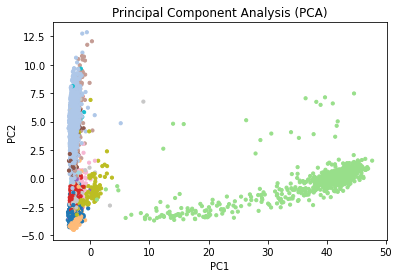


Dimensions of reduced data set: (8617, 10)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.018s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 8617 samples in 1.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 0.517332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.552475
[t-SNE] KL divergence after 1000 iterations: 1.273838


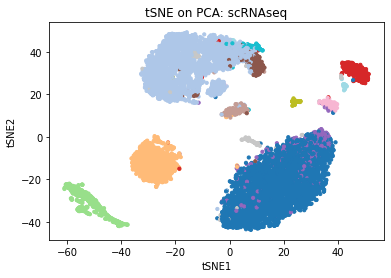

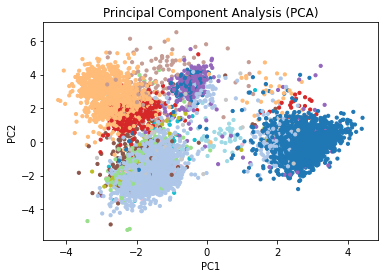


Dimensions of reduced data set: (8617, 10)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.012s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 8617 samples in 1.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 0.471750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.846619
[t-SNE] KL divergence after 1000 iterations: 1.195029


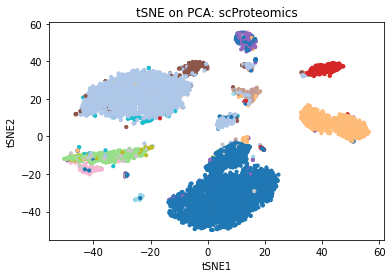

In [ ]:
run_tsne(X_scRNAseq, Y_scRNAseq, 'scRNAseq')

run_tsne(X_scProteomics, Y_scProteomics, 'scProteomics')

Epoch 1/100
54/54 [==============================] - 2s 13ms/step - loss: 17.7128 - Decoder_scRNAseq_loss: 0.2803 - Decoder_scProteomics_loss: 17.4325 - val_loss: 15.4003 - val_Decoder_scRNAseq_loss: 0.0912 - val_Decoder_scProteomics_loss: 15.3091
Epoch 2/100
54/54 [==============================] - 0s 9ms/step - loss: 17.0641 - Decoder_scRNAseq_loss: 0.2056 - Decoder_scProteomics_loss: 16.8585 - val_loss: 15.3891 - val_Decoder_scRNAseq_loss: 0.0803 - val_Decoder_scProteomics_loss: 15.3088
Epoch 3/100
54/54 [==============================] - 1s 9ms/step - loss: 17.0575 - Decoder_scRNAseq_loss: 0.1991 - Decoder_scProteomics_loss: 16.8584 - val_loss: 15.3877 - val_Decoder_scRNAseq_loss: 0.0790 - val_Decoder_scProteomics_loss: 15.3087
Epoch 4/100
54/54 [==============================] - 1s 11ms/step - loss: 17.0553 - Decoder_scRNAseq_loss: 0.1970 - Decoder_scProteomics_loss: 16.8583 - val_loss: 15.3870 - val_Decoder_scRNAseq_loss: 0.0784 - val_Decoder_scProteomics_loss: 15.3086
Epoch 5/10

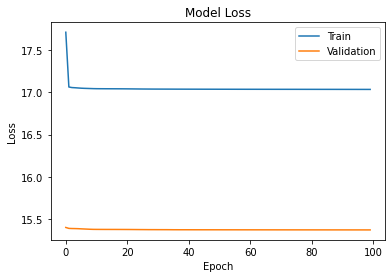

In [ ]:
# Autoencoder training
estimator = autoencoder.fit([X_scRNAseq, X_scProteomics],
                            [X_scRNAseq, X_scProteomics],
                            epochs=100, batch_size=128,
                            validation_split=0.2, shuffle=True, verbose=1)

print("Training Loss: ",estimator.history['loss'][-1])
print("Validation Loss: ",estimator.history['val_loss'][-1])
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.001s...
[t-SNE] Computed neighbors for 8617 samples in 2.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 1.380162
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.420792
[t-SNE] KL divergence after 1000 iterations: 1.430128


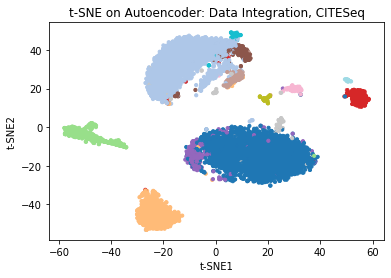

In [ ]:
# Visualise with t-SNE
encoder = Model([input_dim_scRNAseq, input_dim_scProteomics],
                bottleneck)
bottleneck_representation = encoder.predict([X_scRNAseq, X_scProteomics])

# t-SNE on autoencoder bottleneck representation
model_tsne_autoencoder = TSNE(learning_rate=200, n_components=2, random_state=123,
                              perplexity=90, n_iter=1000, verbose=1)

tsne_autoencoder = model_tsne_autoencoder.fit_transform(bottleneck_representation)
plt.scatter(tsne_autoencoder[:, 0], tsne_autoencoder[:, 1], c=Y_scRNAseq, cmap='tab20', s=10)
plt.title('t-SNE on Autoencoder: Data Integration, CITESeq')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

<figure><center>
<img src = https://miro.medium.com/max/658/1*N-IglBtuQF31Q-Ih8ixF5Q.png>
<figcaption> Data Integration allows us to observe new cluster </figcaption>
</center></figure>
Comparing the tSNE plots obtained using individual OMICs with the tSNE on the bottleneck of the Autoencoder that combines the data, we can immediately see that the integration somewhat averages and reinforces the individual OMICs. For example, the purple cluster would be hard to discover using the scRNAseq data alone as it is not distinct from the blue cell population, however after integration the purple group of cells is easily distinguishable.

In [ ]:
# ! wget ftp://ftp.ebi.ac.uk/pub/databases/scnmt_gastrulation/scnmt_gastrulation.tar.gz
# ! gunzip scnmt_gastrulation.tar.gz
# ! ls

## Integrating with scNMTseq data w/ DL
scNMTseq includes 3 omics from the same biological cells:

1) scRNAseq

2) scBSseq

3) scATACseq

<figure><center>
<img src = https://miro.medium.com/max/700/1*Uqm2SKOz8YqQpSs_Hapr3Q.png></center></figure>

The architecture of the Autoencoder is analogous to the one used for CITEseq with only one peculiarity: *Dropout regularization* is used on the input layers. This is due to the fact that we have only ~120 cells sequenced while the dimensionality of the feature space is tens of thousands, so we need to apply regularization to overcome the curse of dimensionality. Note that this was not necessary for CITEseq where we had ~8K cells and ~1K features, so exactly opposite situation. Nevertheless, overall scNMTseq is not an easy case for data integration, I firmly believe though that this is just the beginning of single cell multi-OMICs era and many more cells will arrive soon from this exciting technology, so it is better to be prepared.

In [ ]:
! pip install umap-learn

In [ ]:
! wget https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/DeepLearningDataIntegration/scATACseq.txt
! wget https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/DeepLearningDataIntegration/scRNAseq.txt
! wget https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/DeepLearningDataIntegration/scBSseq.txt

--2022-01-13 07:16:47--  https://github.com/NBISweden/workshop_omics_integration/raw/main/session_ml/DeepLearningDataIntegration/scATACseq.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NBISweden/workshop_omics_integration/main/session_ml/DeepLearningDataIntegration/scATACseq.txt [following]
--2022-01-13 07:16:48--  https://raw.githubusercontent.com/NBISweden/workshop_omics_integration/main/session_ml/DeepLearningDataIntegration/scATACseq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3772209 (3.6M) [text/plain]
Saving to: ‘scATACseq.txt.1’

scATACseq.txt.1     100%[===================

In [ ]:
from umap import UMAP
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, Dropout

################## READ AND TRANSFORM DATA ##################
scRNAseq = pd.read_csv('scRNAseq.txt',sep='\t')
scBSseq = pd.read_csv('scBSseq.txt',sep='\t')
scATACseq = pd.read_csv('scATACseq.txt',sep='\t')

X_scRNAseq = scRNAseq.values[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.values[:,scRNAseq.shape[1]-1]
X_scBSseq = scBSseq.values[:,0:(scBSseq.shape[1]-1)]
Y_scBSseq = scBSseq.values[:,scBSseq.shape[1]-1]
X_scATACseq = scATACseq.values[:,0:(scATACseq.shape[1]-1)]
Y_scATACseq = scATACseq.values[:,scATACseq.shape[1]-1]

# Log transform
X_scRNAseq = np.log(X_scRNAseq + 1)
X_scBSseq = np.log(X_scBSseq + 1)
X_scATACseq = np.log(X_scATACseq + 1)

print(X_scRNAseq.shape)
print(Y_scRNAseq.shape)
print(X_scATACseq.shape)
print(Y_scATACseq.shape)
print(X_scBSseq.shape)
print(Y_scBSseq.shape)

(113, 12313)
(113,)
(113, 11799)
(113,)
(113, 8574)
(113,)


We can again display the tSNE embeddings of the individual scRNAseq layes from the scNMT data set before integrating it together with scBSseq & scATACseq with Autoencoder

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.001s...
[t-SNE] Computed neighbors for 113 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 10.558876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.429222
[t-SNE] KL divergence after 1000 iterations: 0.336728


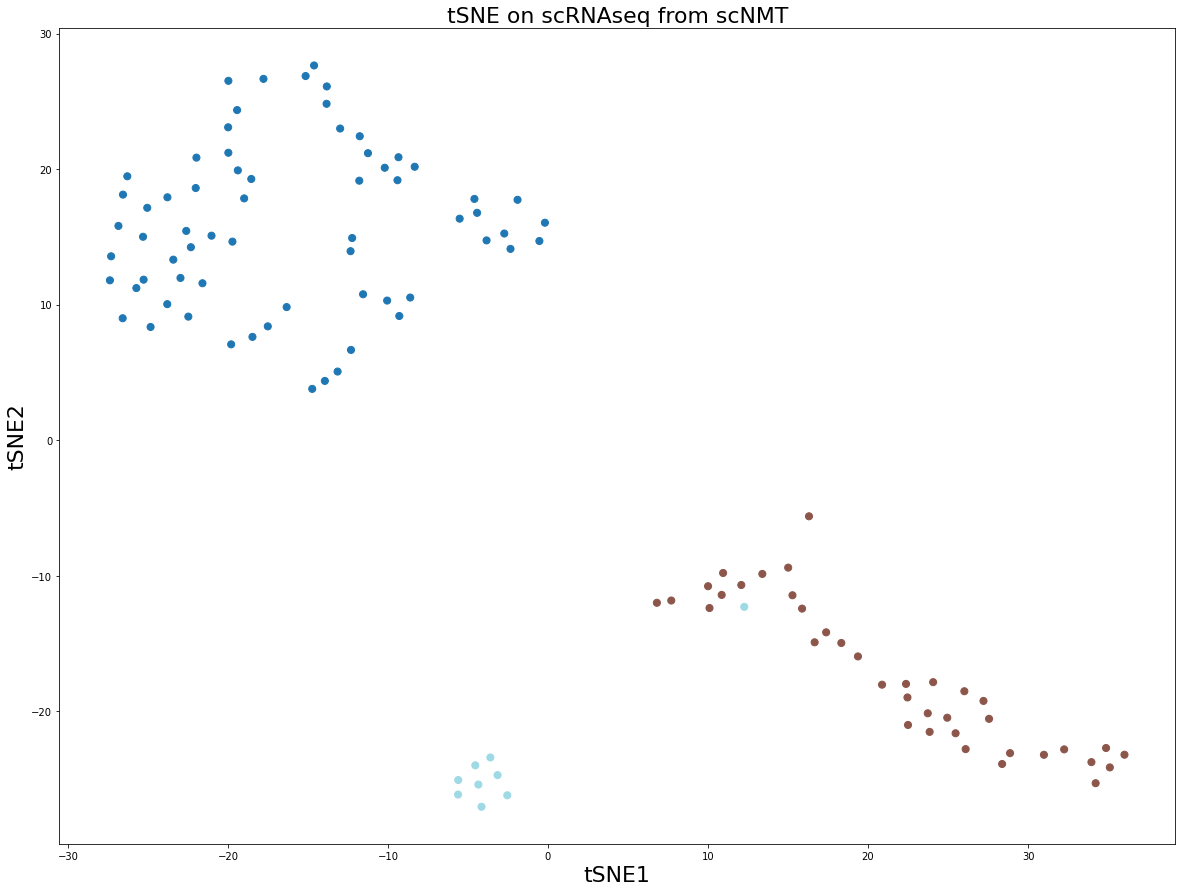

In [ ]:
from sklearn.decomposition import PCA

X_reduced = PCA(n_components=5).fit_transform(X_scRNAseq)

model_tsne_scRNAseq = TSNE(n_components=2, random_state=123, perplexity=10, n_iter=1000, verbose=1)
tsne_scRNAseq = model_tsne_scRNAseq.fit_transform(X_reduced)

plt.figure(figsize = (20,15))
plt.scatter(tsne_scRNAseq[:, 0], tsne_scRNAseq[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 50)
plt.title('tSNE on scRNAseq from scNMT', fontsize = 22)
plt.xlabel("tSNE1", fontsize = 22)
plt.ylabel("tSNE2", fontsize = 22)
plt.show()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 scRNAseq (InputLayer)          [(None, 12313)]      0           []                               
                                                                                                  
 scBSseq (InputLayer)           [(None, 8574)]       0           []                               
                                                                                                  
 scATACseq (InputLayer)         [(None, 11799)]      0           []                               
                                                                                                  
 Dropout_scRNAseq (Dropout)     (None, 12313)        0           ['scRNAseq[0][0]']               
                                                                                           

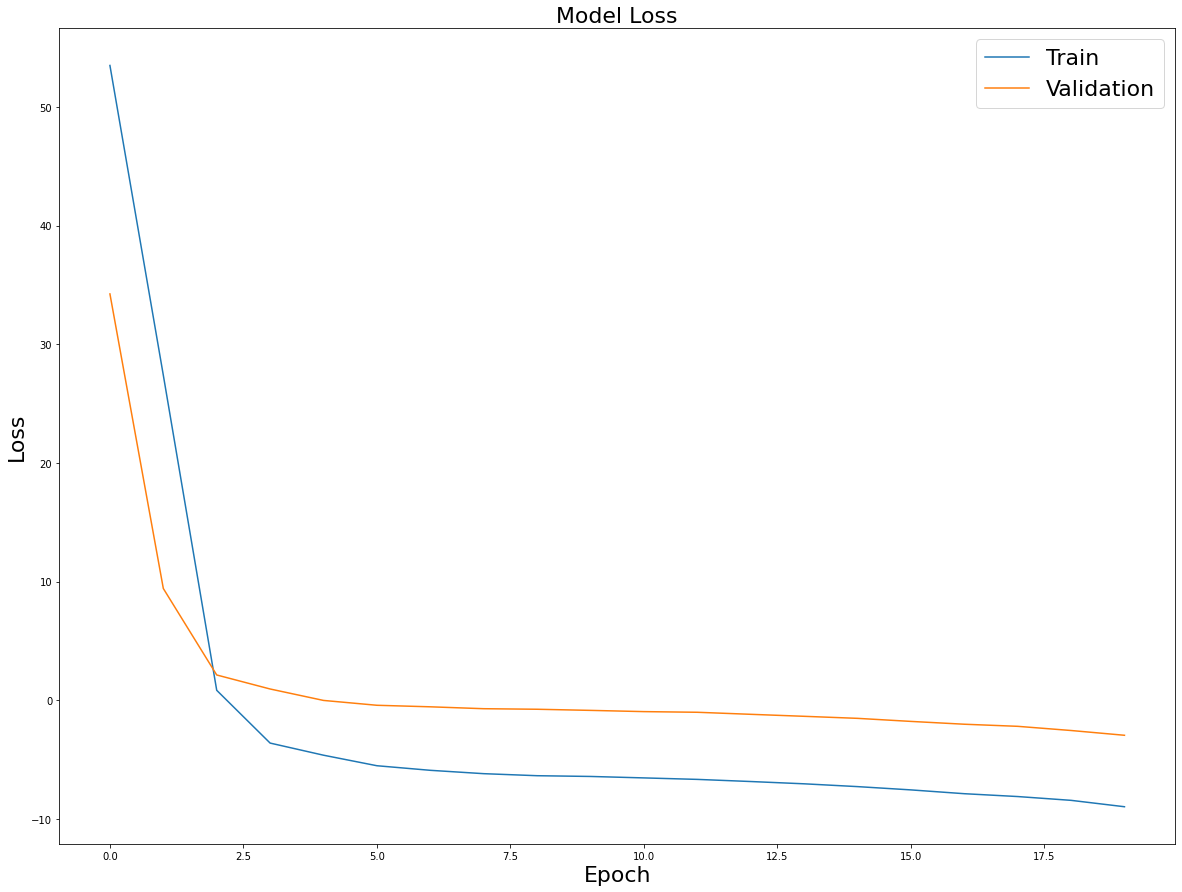

In [ ]:
######################## AUTOENCODER ########################
# Input Layer
ncol_scRNAseq = X_scRNAseq.shape[1]
input_dim_scRNAseq = Input(shape = (ncol_scRNAseq, ), name = "scRNAseq")
ncol_scBSseq = X_scBSseq.shape[1]
input_dim_scBSseq = Input(shape = (ncol_scBSseq, ), name = "scBSseq")
ncol_scATACseq = X_scATACseq.shape[1]
input_dim_scATACseq = Input(shape = (ncol_scATACseq, ), name = "scATACseq")

encoding_dim_scRNAseq = 10
encoding_dim_scBSseq = 10
encoding_dim_scATACseq = 10

# Dropout on Input Layer
dropout_scRNAseq = Dropout(0.2, name = "Dropout_scRNAseq")(input_dim_scRNAseq)
dropout_scBSseq = Dropout(0.2, name = "Dropout_scBSseq")(input_dim_scBSseq)
dropout_scATACseq = Dropout(0.2, name = "Dropout_scATACseq")(input_dim_scATACseq) 

# Encoder layer for each OMIC
encoded_scRNAseq = Dense(encoding_dim_scRNAseq, activation = 'elu', 
                         name = "Encoder_scRNAseq")(dropout_scRNAseq)
encoded_scBSseq = Dense(encoding_dim_scBSseq, activation = 'elu', 
                        name = "Encoder_scBSseq")(dropout_scBSseq)
encoded_scATACseq = Dense(encoding_dim_scATACseq, activation = 'elu', 
                          name = "Encoder_scATACseq")(dropout_scATACseq)

# Merging Encoder layers from different OMICs
merge = concatenate([encoded_scRNAseq, encoded_scBSseq, encoded_scATACseq])

# Bottleneck compression
bottleneck = Dense(5, kernel_initializer = 'uniform', activation = 'elu', 
                   name = "Bottleneck")(merge)

#Inverse merging
merge_inverse = Dense(encoding_dim_scRNAseq + encoding_dim_scBSseq + 
                      encoding_dim_scATACseq, 
                      activation = 'elu', name = "Concatenate_Inverse")(bottleneck)

# Decoder layer for each OMIC
decoded_scRNAseq = Dense(ncol_scRNAseq, activation = 'elu', 
                         name = "Decoder_scRNAseq")(merge_inverse)
decoded_scBSseq = Dense(ncol_scBSseq, activation = 'elu', 
                        name = "Decoder_scBSseq")(merge_inverse)
decoded_scATACseq = Dense(ncol_scATACseq, activation = 'elu', 
                          name = "Decoder_scATACseq")(merge_inverse)

# Combining Encoder and Decoder into an Autoencoder model
autoencoder = Model([input_dim_scRNAseq, input_dim_scBSseq, input_dim_scATACseq], 
                    [decoded_scRNAseq, decoded_scBSseq, decoded_scATACseq])

# Compile Autoencoder
autoencoder.compile(optimizer = 'adam', 
                    loss={'Decoder_scRNAseq': 'mean_squared_error', 
                          'Decoder_scBSseq': 'binary_crossentropy', 
                          'Decoder_scATACseq': 'binary_crossentropy'})
autoencoder.summary()

# Autoencoder training
estimator = autoencoder.fit([X_scRNAseq, X_scBSseq, X_scATACseq], 
                            [X_scRNAseq, X_scBSseq, X_scATACseq], epochs = 20, 
                            batch_size = 16, validation_split = 0.2, 
                            shuffle = True, verbose = 0)
print("Training Loss: ",estimator.history['loss'][-1])
print("Validation Loss: ",estimator.history['val_loss'][-1])

plt.figure(figsize = (20,15))
plt.plot(estimator.history['loss']); plt.plot(estimator.history['val_loss'])
plt.title('Model Loss', fontsize = 22); plt.ylabel('Loss', fontsize = 22); plt.xlabel('Epoch', fontsize = 22)
plt.legend(['Train','Validation'], loc = 'upper right', fontsize = 22)


Text(0, 0.5, 'UMAP2')

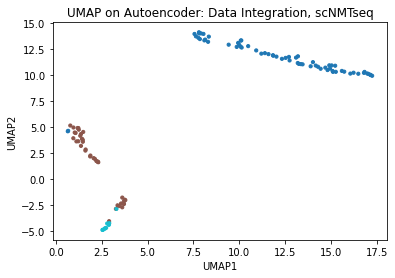

In [ ]:
# Encoder model
encoder = Model([input_dim_scRNAseq, input_dim_scBSseq, input_dim_scATACseq], 
                bottleneck)
bottleneck_representation = encoder.predict([X_scRNAseq, X_scBSseq, X_scATACseq])

############### UNIFORM MANIFOLD APPROXIMATION AND PROJECTION (UMAP) ###############
model_umap = UMAP(n_neighbors = 11, min_dist = 0.1, n_components = 2)
umap = model_umap.fit_transform(bottleneck_representation)
plt.scatter(umap[:, 0], umap[:, 1], c = Y_scRNAseq, cmap = 'tab10', s = 10)
plt.title('UMAP on Autoencoder: Data Integration, scNMTseq')
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")

(113, 5)
           0         1           2    3    4
0  78.364853 -1.000000  109.677765 -1.0 -1.0
1  73.661469 -1.000000  101.843758 -1.0 -1.0
2  83.838577 -1.000000  114.090080 -1.0 -1.0
3  78.306953 -1.000000  109.488098 -1.0 -1.0
4  77.244560 -0.999999  107.983032 -1.0 -1.0


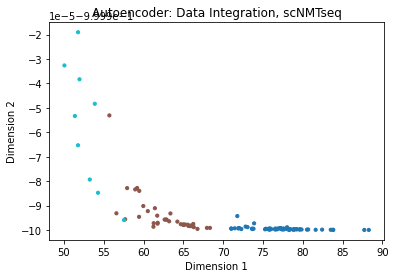

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 113 samples in 0.001s...
[t-SNE] Computed neighbors for 113 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 113 / 113
[t-SNE] Mean sigma: 1.290762
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.873306
[t-SNE] KL divergence after 1000 iterations: 0.153703


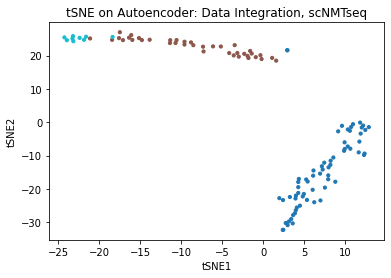

In [ ]:
print(pd.DataFrame(bottleneck_representation).shape)
print(pd.DataFrame(bottleneck_representation).iloc[0:5,0:5])

# Dimensionality reduction plot
#plt.figure(figsize=(20, 15))
plt.scatter(bottleneck_representation[:, 0], bottleneck_representation[:, 1], c = Y_scRNAseq, cmap = 'tab10', s = 10)
plt.title('Autoencoder: Data Integration, scNMTseq')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.colorbar()
plt.show()

# tSNE on Autoencoder bottleneck representation
model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, perplexity = 11, n_iter = 1000, verbose = 1)
tsne_auto = model_tsne_auto.fit_transform(bottleneck_representation)
plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab10', s = 10)
plt.title('tSNE on Autoencoder: Data Integration, scNMTseq')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()


First observation is that UMAP seems to outperform t-SNE in sense of scalability for large amounts of data. We can also immediately see that the homogeneous in sense of gene expression blue cluster splits into two clusters when scRNAseq is combined with epigenetics information from the same cells (scBSseq and scATACseq). Therefore it seems that we have captured a new heterogeneity between cells which was hidden when looking only at gene expression scRNAseq data. Can this be a new way of classifying cells across populations by using the whole complexity of their biology? If so, then the question comes: what is a cell population or cell type? I do not know the answer for this question.

## Pamona

Another method recently developed for data integration is [Manifold alignment for heterogeneous single-cell multi-omics using Pamona](https://doi.org/10.1101/2020.11.03.366146). Details and code for the package can be found in [github](https://github.com/caokai1073/Pamona)

In [ ]:
! pip install pamona
! pip install POT

     |████████████████████████████████| 656 kB 5.5 MB/s 
     |████████████████████████████████| 15.7 MB 51.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
data = [X_scRNAseq, X_scATACseq, X_scBSseq]

Y_scRNAseq = Y_scRNAseq.astype(np.int)
Y_scATACseq = Y_scATACseq.astype(np.int)
Y_scBSseq = Y_scBSseq.astype(np.int)

datatype = [Y_scRNAseq, Y_scATACseq, Y_scBSseq]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

In [ ]:
from pamona import Pamona

Pa = Pamona.Pamona(n_neighbors=40, Lambda=10)
integrated_data, T = Pa.run_Pamona(data)

Pamona start!
use random seed: 666
Epoch.|Loss        
-------------------
    0|2.193579e-02|


/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|5.809940e-03|
   20|7.333900e-04|
   30|1.870973e-05|
   40|1.829785e-07|
   50|1.757756e-09|
   60|1.688282e-11|
Epoch.|Loss        
-------------------
    0|1.777564e-02|
   10|6.235931e-03|
   20|1.208824e-03|
   30|6.358162e-04|
   40|2.058104e-05|
   50|2.531227e-06|
   60|5.626579e-07|
   70|1.426182e-07|
   80|3.714069e-08|
   90|9.714581e-09|
  100|2.542427e-09|
  110|6.654026e-10|
Pamona Done! takes 21.019279 seconds


In [ ]:
Pa.alignment_score(integrated_data[0], integrated_data[-1])
Pa.test_LabelTA(integrated_data[0], integrated_data[-1], Y_scRNAseq, Y_scBSseq)

alignment score:
1.0991150442477877
label transfer accuracy:
0.6460176991150443


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2

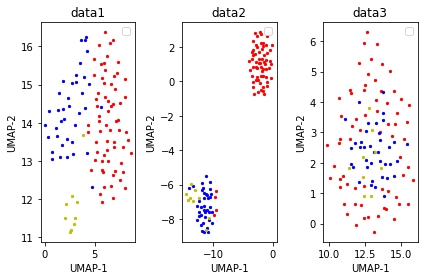

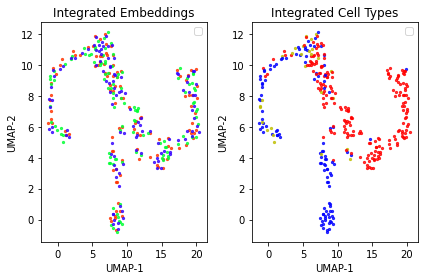

In [ ]:
Pa.Visualize([X_scRNAseq, X_scATACseq, X_scBSseq], integrated_data, 
             [Y_scRNAseq, Y_scATACseq, Y_scBSseq], mode='UMAP') # with datatype
